In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Descriptives
Data exploration and basic descriptives, including:
 * Name and franchise code (non independent observations)
 * Bank
 * Correlations

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, especially:
* https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer

I am also not going to use all the features I could.  I want to focus on NAICS, and so I don't do a lot with bank, franchise, or geography.

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re, importlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

## Import Data

In [5]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [6]:
sba_loans.shape

(688081, 58)

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy().reset_index(drop=True)

##### NAICS descriptions

In [8]:
naics_desc = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet')) \
    .drop_duplicates('NAICS07')

## Name and Franchise
These features are important to me because they may indicate non-independent observations.  There may be multiple loans for the same business.  Or, we may have multiple branches of a franchise who are not independent

For this project I am not likely to do anything to account for potential leakage or distortions due to non-independence.  This may be something a GNN will be helpful for and I may explore that in the future

I am not even going to do my train/test split by name or franchise, which would normally be the minimum I'd do with non-independent observations

##### Name - are there repeat loans?

In [9]:
print(sba_loans.shape)
print(sba_loans.drop_duplicates(['Name']).shape)
print(sba_loans.drop_duplicates(['Name', 'Zip', 'City', 'State']).shape)

(688081, 58)
(604551, 58)
(641628, 58)


In [10]:
# It looks like most repeat names are multi-locations (same name different address(  
# There are a few same name/location cases, probably the same business getting multiple loans.

In [11]:
sba_loans['Name'].value_counts().head(5)

Name
SUBWAY                 913
QUIZNO'S SUBS          412
COLD STONE CREAMERY    348
THE UPS STORE          321
QUIZNO'S               310
Name: count, dtype: int64

In [12]:
# It appears that large franchises are getting many loans

In [13]:
sba_loans.groupby(['Name', 'Zip', 'City', 'State'])['franchise_flag'] \
    .agg(['count', 'mean']) \
    .sort_values('count', ascending=False) \
    .head()

,,,,count,mean
Name,Zip,City,State,,
WEST TEXAS LEE CO INC,79329,IDALOU,TX,39,0.0
"ERIE PETROLEUM, INC.",16512,ERIE,PA,25,0.0
"Meathead Movers, Inc.",93401,SAN LUIS OBISPO,CA,23,0.0
"COLCHESTER HOLDINGS, INC.",13755,DOWNSVILLE,NY,18,0.0
UNITED STEEL FABRICATORS,45365,SIDNEY,OH,15,0.0


In [14]:
# There are some non-franchises getting tons of loans also

## Banks
I won't do anything with bank for this project, but it could also be an interesting GNN application in the future

##### Bank - loans per bank and histogram

In [15]:
sba_loans['Bank'].value_counts(dropna=False).head()

Bank
BANK OF AMERICA NATL ASSOC        74591
WELLS FARGO BANK NATL ASSOC       42259
JPMORGAN CHASE BANK NATL ASSOC    41012
CITIZENS BANK NATL ASSOC          32227
U.S. BANK NATIONAL ASSOCIATION    26866
Name: count, dtype: int64

In [16]:
sba_loans['Bank'].value_counts(dropna=False).shape

(5133,)

In [17]:
sba_count = sba_loans.groupby('Bank')['LoanNr_ChkDgt']\
    .agg(['count'])

In [18]:
sba_count.describe()
# Most banks are small.  There are a few mega-banks.  

,count
count,5132.000000
mean,133.980904
std,1596.001329
min,1.000000
25%,2.000000
50%,8.000000
75%,34.000000
max,74591.000000


## Correlations
Get correlations for all predictor features, as well as Term, the target indicator

naics_num = train_df.filter(like='NAICS', dtype='number').columns##### Calculate Spearman correlations

In [19]:
naics_num = train_df.filter(like='NAICS').select_dtypes('number').columns
naics_num

Index(['NAICS_num', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4',
       'menc_NAICS_3', 'menc_NAICS_sector', 'mhier_NAICS', 'cenc_NAICS'],
      dtype='object')

In [20]:
# Correlations matrix
cor_df = train_df[['Term', 'target'] + list(naics_num) + \
                    setup.predictor_features].corr(method='spearman')

In [21]:
cor_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_correlations.csv'), index=True)

##### Function to examine correlations for a given feature

In [22]:
def feat_corr(corr_data, feature='target',
             outpath = None,
             outfile_prefix = '02_PLOT_cor_'):
    feat_corr = corr_data[feature].rename('corr').reset_index()
    feat_corr['corr_abs'] = np.abs(feat_corr['corr'])
    feat_corr = feat_corr[feat_corr['index'] != feature]
    feat_corr.sort_values('corr_abs', ascending=False, inplace=True)
    
    fig = sg_plot.plot_basic_bar(feat_corr, label='index', y='corr')
    
    if outpath is not None:
        fig.savefig(Path(outpath).joinpath(outfile_prefix + feature))
        
    #print(fig)
              
    return feat_corr

##### Target correlations

,index,corr,corr_abs
0,Term,-0.448744,0.448744
8,mhier_NAICS,0.237770,0.237770
3,menc_NAICS,0.237281,0.237281
4,menc_NAICS_5,0.230015,0.230015
5,menc_NAICS_4,0.211327,0.211327
6,menc_NAICS_3,0.180794,0.180794
13,DisbursementGross,-0.163556,0.163556
10,NoEmp,-0.107373,0.107373
7,menc_NAICS_sector,0.102591,0.102591
12,LowDoc,-0.079523,0.079523


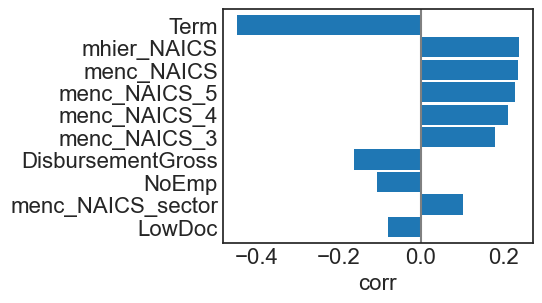

In [23]:
feat_corr(cor_df, 'target', outpath = Path(setup.temp_path))

The target feature is highly correlated with term (in Kaggle notebooks, models have very high performance, and I also see very high performance with this feature).  I think this feature is likely set by the creditworthiness of the businesses, as it is such a strong predictor

After term, NAICS seems to be the most significant feature.  Let's look at the NAICS feature now

##### NAICS correlations
NAICS mean encoding vs. non-NAICS features

In [24]:
feat_list = [c for c in cor_df.index if not 'menc_grp' in c]

,index,corr,corr_abs
8,mhier_NAICS,0.998017,0.998017
4,menc_NAICS_5,0.969070,0.969070
5,menc_NAICS_4,0.890684,0.890684
6,menc_NAICS_3,0.756346,0.756346
7,menc_NAICS_sector,0.415166,0.415166
13,DisbursementGross,-0.265545,0.265545
0,Term,-0.240786,0.240786
1,target,0.237281,0.237281
10,NoEmp,-0.136917,0.136917
12,LowDoc,-0.081817,0.081817


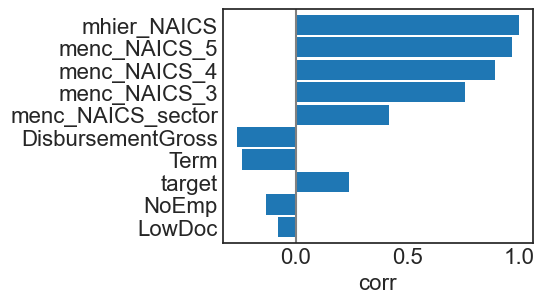

In [25]:
feat_corr(cor_df[cor_df.index.isin(feat_list)], 
                 'menc_NAICS', outpath = Path(setup.temp_path))

There are strong correlations with RevLineCr, RetainedJob, and other features. 

## Term
This feature is highly predictive and its use makes an excellent model.  I will probably drop it as it's probably set in proportion to creditworthiness.  Using this feature would make sense if you want to evaluate how well SBA is assigning risk, or to predict defaults given known risk.  But here I omit it because it makes a model so good NAICS doesn't matter.  Also removing this feature means predicting risk without the (implicit) benefit of the credit-worthiness assigned by the SBA.

I am going to explore how term is related to the target a little

##### Quartile stats

In [26]:
train_df['term_cat'] = pd.qcut(train_df['Term'], q=4)

In [27]:
train_df.groupby('term_cat') \
    .agg({'Term': 'mean', 'LoanNr_ChkDgt':'count',
          'target':'mean'})

,Term,LoanNr_ChkDgt,target
term_cat,,,
"(-0.001, 60.0]",40.458039,138748,0.433044
"(60.0, 84.0]",81.193118,154905,0.116220
"(84.0, 120.0]",110.812550,58026,0.127460
"(120.0, 569.0]",237.008148,84441,0.044658


There is a steady decrease in risk as term increases.  I wonder if enough time has passed to evaluate very long loans

##### Value counts, describe

In [28]:
train_df['Term'].value_counts().head(10)

Term
84     121763
60      41689
120     34408
240     34147
300     17547
36      10460
180      9607
12       8320
48       7912
72       4667
Name: count, dtype: int64

5 or 7 year terms are common!

In [29]:
train_df['Term'].describe()

count    436120.000000
mean        102.343176
std          74.297505
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

## NAICS

##### Code level stats

In [30]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [31]:
naics_grp = ['NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']

In [32]:
stats_all = pd.concat([sg_plot.naics_grp_stats(sba_loans, c) for c in naics_grp],
                      keys=naics_grp)
stats_all.reset_index().to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_all.csv'), 
                               index=False)
stats_all

count_grp          mean        median         min  \
NAICS_5      loan_count        834.0    825.037170    247.500000    1.000000   
             target            834.0      0.187676      0.166667    0.000000   
             low_vol           834.0      0.182254      0.000000    0.000000   
             naics_count       834.0      1.571942      1.000000    1.000000   
             single_naics      834.0      0.735012      1.000000    0.000000   
NAICS_4      loan_count        354.0   1943.731638    547.500000    1.000000   
             target            354.0      0.184428      0.170639    0.000000   
             low_vol           354.0      0.090395      0.000000    0.000000   
             naics_count       354.0      3.703390      3.000000    1.000000   
             single_naics      354.0      0.231638      0.000000    0.000000   
NAICS_3      loan_count        106.0   6491.330189   2135.500000    1.000000   
             target            106.0      0.198674      0.187819    0.000000   
             low_vol           106.0      0.075472      0.000000    0.000000   
             naics_count       106.0     12.367925      9.000000    1.000000   
             single_naics      106.0      0.047170      0.000000    0.000000   
NAICS_sector loan_count         20.0  34404.050000  18430.500000  225.000000   
             target             20.0      0.193514      0.202050    0.082003   
             low_vol            20.0      0.000000      0.000000    0.000000   
             naics_count        20.0     65.550000     43.500000    3.000000   
             single_naics       20.0      0.000000      0.000000    0.000000   

                                     max            sum  
NAICS_5      loan_count     27941.000000  688081.000000  
             target             1.000000     156.522000  
             low_vol            1.000000     152.000000  
             naics_count       10.000000    1311.000000  
             single_naics       1.000000     613.000000  
NAICS_4      loan_count     31793.000000  688081.000000  
             target             1.000000      65.287573  
             low_vol            1.000000      32.000000  
             naics_count       19.000000    1311.000000  
             single_naics       1.000000      82.000000  
NAICS_3      loan_count     67465.000000  688081.000000  
             target             1.000000      21.059405  
             low_vol            1.000000       8.000000  
             naics_count       53.000000    1311.000000  
             single_naics       1.000000       5.000000  
NAICS_sector loan_count    125289.000000  688081.000000  
             target             0.288524       3.870287  
             low_vol            0.000000       0.000000  
             naics_count      488.000000    1311.000000  
             single_naics       0.000000       0.000000

In [57]:
stats_train = pd.concat([sg_plot.naics_grp_stats(sba_loans[sba_loans['dset'] == 'train'], c) for c in naics_grp],
                      keys=naics_grp)
stats_train.reset_index().to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_train.csv'), 
                                 index=False)
stats_train

count_grp          mean        median         min  \
NAICS_5      loan_count        770.0    566.389610    170.500000    1.000000   
             target            770.0      0.181508      0.165257    0.000000   
             low_vol           770.0      0.237662      0.000000    0.000000   
             naics_count       770.0      1.514286      1.000000    1.000000   
             single_naics      770.0      0.745455      1.000000    0.000000   
NAICS_4      loan_count        348.0   1253.218391    375.500000    1.000000   
             target            348.0      0.179101      0.166650    0.000000   
             low_vol           348.0      0.137931      0.000000    0.000000   
             naics_count       348.0      3.350575      3.000000    1.000000   
             single_naics      348.0      0.267241      0.000000    0.000000   
NAICS_3      loan_count        105.0   4153.523810   1330.000000    2.000000   
             target            105.0      0.189477      0.184604    0.000000   
             low_vol           105.0      0.095238      0.000000    0.000000   
             naics_count       105.0     11.104762      8.000000    1.000000   
             single_naics      105.0      0.057143      0.000000    0.000000   
NAICS_sector loan_count         20.0  21806.000000  12022.000000  120.000000   
             target             20.0      0.195860      0.205308    0.087214   
             low_vol            20.0      0.000000      0.000000    0.000000   
             naics_count        20.0     58.300000     40.000000    3.000000   
             single_naics       20.0      0.000000      0.000000    0.000000   

                                    max            sum  
NAICS_5      loan_count    19570.000000  436120.000000  
             target            1.000000     139.761336  
             low_vol           1.000000     183.000000  
             naics_count      10.000000    1166.000000  
             single_naics      1.000000     574.000000  
NAICS_4      loan_count    19570.000000  436120.000000  
             target            0.443378      62.327317  
             low_vol           1.000000      48.000000  
             naics_count      17.000000    1166.000000  
             single_naics      1.000000      93.000000  
NAICS_3      loan_count    40029.000000  436120.000000  
             target            0.422811      19.895132  
             low_vol           1.000000      10.000000  
             naics_count      44.000000    1166.000000  
             single_naics      1.000000       6.000000  
NAICS_sector loan_count    82957.000000  436120.000000  
             target            0.286911       3.917200  
             low_vol           0.000000       0.000000  
             naics_count     424.000000    1166.000000  
             single_naics      0.000000       0.000000

##### Variation Plots (Sectors)
What is the variation of term rates within vs. between sectors?

In [34]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [35]:
# Summarize target rates and counts by NAICS
naics_info = sg_plot.naics_variance_data(sba_loans)
naics_info = naics_info.merge(naics_desc.rename(columns={'NAICS07':'NAICS'}),
                             how='left', on='NAICS')
naics_info.to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates.csv'), index=False)

In [36]:
# Join in NAICS code descriptions

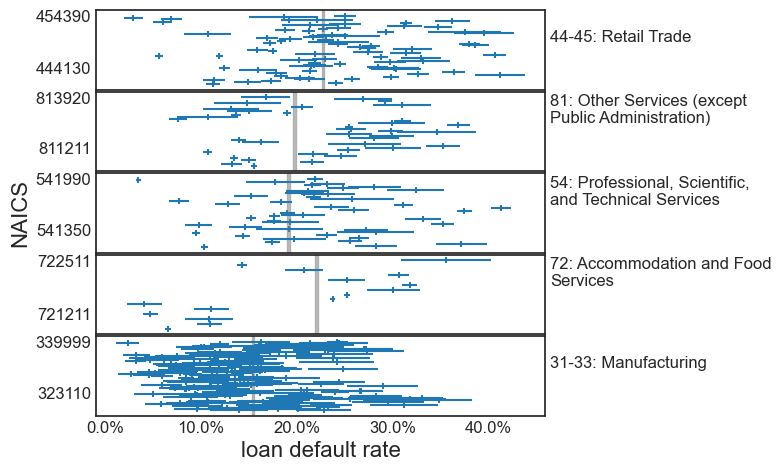

In [37]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100], num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_100.png'),
           bbox_inches='tight')

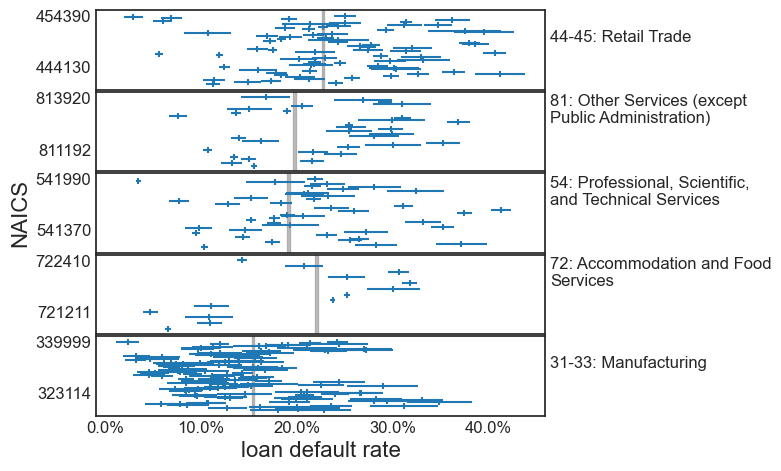

In [38]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150], num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_150.png'),
           bbox_inches='tight')

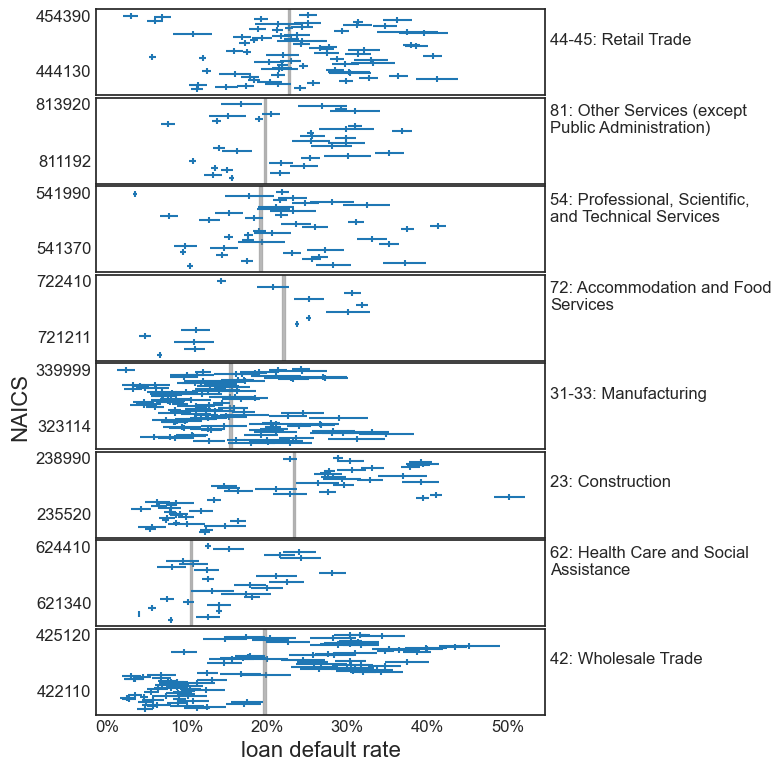

In [39]:
# Get top 8
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150], num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_150_top8.png'),
           bbox_inches='tight')

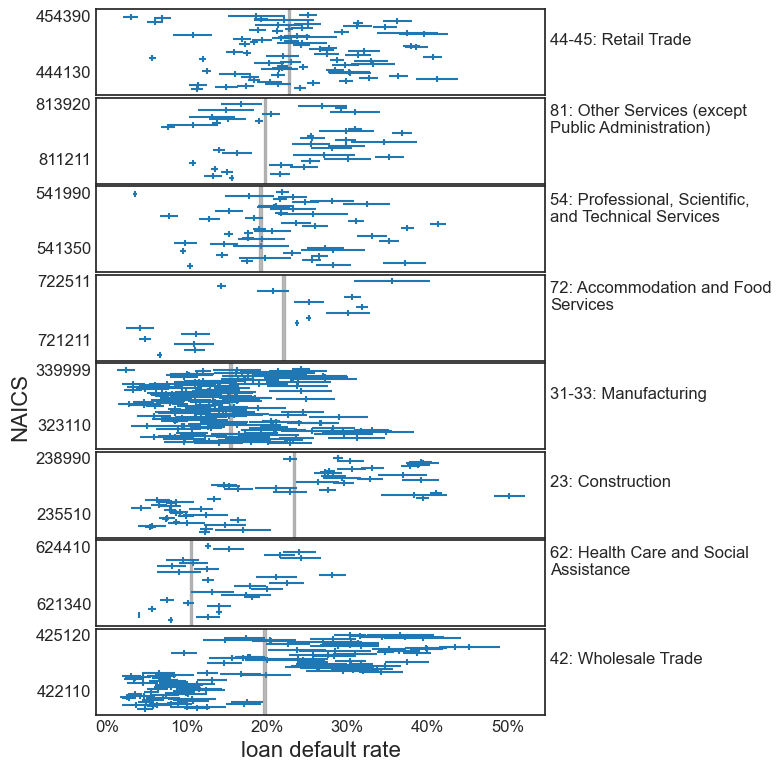

In [40]:
# Get top 8
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100], num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_100_top8.png'),
           bbox_inches='tight')

In [41]:
# Export high-volume data for analysis
naics_info[naics_info['count_naics'] >= 100] \
           .sort_values(['target_cat', 'target_naics'], ascending=[False, False]) \
           .to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates_high_vol.csv'), 
                   index=False)

## NAICS mean enodings
Examine where values differ - expect at low counts.  Focus on the training data

In [42]:
train_df =  sba_loans[sba_loans['dset'] == 'train'] 

In [43]:
train_naics_mean = train_df.groupby('NAICS')['target'].agg(['mean', 'count']) \
    .set_axis(['target', 'count'], axis=1) \
    .reset_index()

In [44]:
train_sector_mean = train_df.groupby('NAICS_sector')['target'].agg('mean') \
    .rename('sector_mean') \
    .reset_index()

In [45]:
train_df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'target', 'guaranteed_fract', 'new_business', 'urban_flag',
       'franchise_flag', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
       'NAICS_num', 'dset', 'dset_naics_holdout', 'NAICS_5', 'NAICS_4',
       'NAICS_3', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3',
       'menc_NAICS_sector', 'mhier_NAICS',
       'NS___Accommodation and Food Services',
       'NS___Administrative and Support and Waste Management and Remediation Services',
       'NS___Construction', 'NS___Health Care and Social Assistance',
       'NS___Manufacturing',
       'NS___Other Services (except Public Administra

In [46]:
naics_menc_info = train_df \
    [['NAICS', 'NAICS_sector'] + list(naics_num)]  \
    .groupby('NAICS') \
    .head(1) \
    .reset_index() \
    .merge(train_naics_mean, on='NAICS') \
    .merge(train_sector_mean, on='NAICS_sector')

In [47]:
naics_menc_info['diff'] = naics_menc_info['menc_NAICS'] - naics_menc_info['menc_NAICS_sector']
naics_menc_info['diff_abs'] = np.abs(naics_menc_info['diff'])

<Axes: xlabel='count', ylabel='diff_abs'>

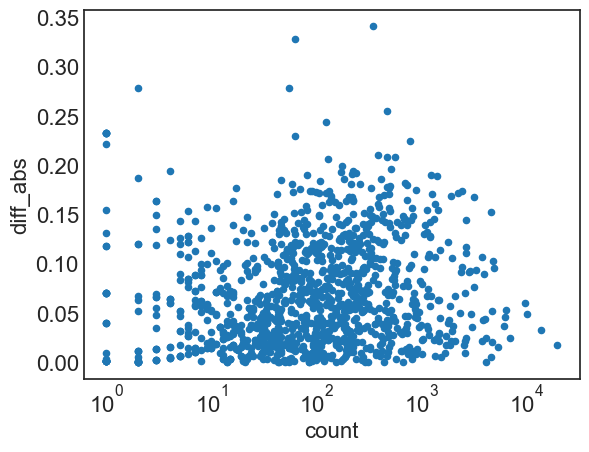

In [48]:
naics_menc_info.plot(x='count', y='diff_abs', kind='scatter',
                    logx=True)

In [49]:
naics_menc_info['quantile'] = pd.qcut(naics_menc_info['count'], q=10)

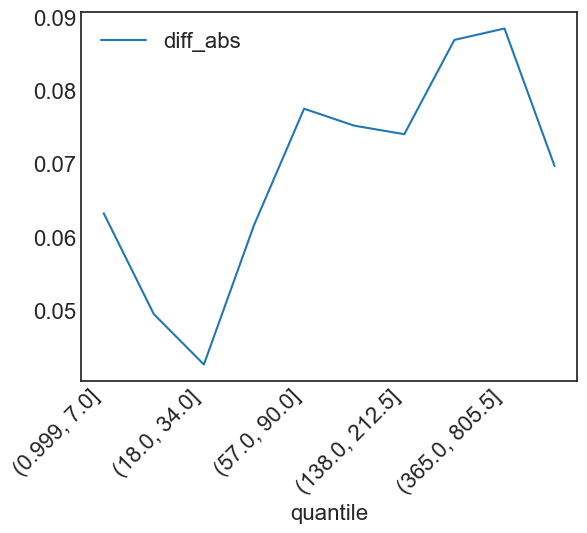

In [50]:
naics_menc_info.groupby('quantile')[['diff_abs']].agg('mean') \
    .plot()
_ = plt.xticks(rotation=45, ha='right')

In [51]:
naics_menc_info.sort_values('diff_abs', ascending=False).head(3)

,index,NAICS,NAICS_sector,NAICS_num,menc_NAICS,menc_NAICS_5,menc_NAICS_4,menc_NAICS_3,menc_NAICS_sector,mhier_NAICS,cenc_NAICS,target,count,sector_mean,diff,diff_abs,quantile
1072,6461,114112,11,114112.0,0.428161,0.269492,0.269492,0.261218,0.087214,0.428161,0.000798,0.428161,348,0.087214,0.340947,0.340947,"(212.5, 365.0]"
66,10044,452112,44-45,452112.0,0.551324,0.364706,0.364706,0.295562,0.223429,0.572148,0.000144,0.603175,63,0.223429,0.327895,0.327895,"(57.0, 90.0]"
1162,261103,212325,21,212325.0,0.395927,0.174365,0.154813,0.137931,0.117409,0.372914,0.000005,1.000000,2,0.117409,0.278518,0.278518,"(0.999, 7.0]"


In [52]:
naics_menc_info.sort_values('count', ascending=False).head(5)

,index,NAICS,NAICS_sector,NAICS_num,menc_NAICS,menc_NAICS_5,menc_NAICS_4,menc_NAICS_3,menc_NAICS_sector,mhier_NAICS,cenc_NAICS,target,count,sector_mean,diff,diff_abs,quantile
159,123,722110,72,722110.0,0.236382,0.236382,0.236382,0.240226,0.218456,0.236382,0.044873,0.236382,19570,0.218456,0.017926,0.017926,"(805.5, 19570.0]"
158,24,722211,72,722211.0,0.251133,0.264023,0.264023,0.240226,0.218456,0.251133,0.031372,0.251133,13682,0.218456,0.032677,0.032677,"(805.5, 19570.0]"
110,10,811111,81,811111.0,0.151928,0.152833,0.154375,0.169607,0.201483,0.151928,0.022895,0.151928,9985,0.201483,-0.049555,0.049555,"(805.5, 19570.0]"
77,2,621210,62,621210.0,0.040818,0.040818,0.040818,0.089955,0.100917,0.040818,0.022189,0.040818,9677,0.100917,-0.060098,0.060098,"(805.5, 19570.0]"
78,21,624410,62,624410.0,0.126003,0.126003,0.126003,0.137824,0.100917,0.126003,0.015996,0.126003,6976,0.100917,0.025087,0.025087,"(805.5, 19570.0]"


In [53]:
train_df['target'].mean()

0.2046546821975603

## Holdout NAICS

In [54]:
holdout_sum_01 = sba_loans.groupby(['dset', 'dset_naics_holdout']) \
    .agg({'LoanNr_ChkDgt':'count', 'NAICS_sector':pd.Series.nunique, 'NAICS':pd.Series.nunique}) \
    .reset_index() 

In [55]:
holdout_sum_02 = sba_loans.groupby(['dset', 'dset_naics_holdout', 'NAICS']) \
    ['LoanNr_ChkDgt'] \
    .agg('count') \
    .groupby(['dset', 'dset_naics_holdout']) \
    .agg(['mean', 'median', 'min', 'max']) 
holdout_sum_02.columns = ['loans_naics_' + c for c in holdout_sum_02.columns]
holdout_sum_02.reset_index(inplace=True)

In [56]:
holdout_stats = holdout_sum_01.merge(holdout_sum_02, on=['dset', 'dset_naics_holdout'])
holdout_stats.to_csv(Path(setup.temp_path).joinpath('02_REPORT_holdout_naics.csv'), index=False)
holdout_stats

,dset,dset_naics_holdout,LoanNr_ChkDgt,NAICS_sector,NAICS,loans_naics_mean,loans_naics_median,loans_naics_min,loans_naics_max
0,test,0,93455,20,1087,85.975161,23.0,1,4211
1,test,1,65052,18,131,496.580153,102.0,1,6104
2,train,0,436120,20,1166,374.030875,90.0,1,19570
3,val,0,93454,20,1100,84.958182,21.0,1,4160
